In [1]:
import json
import pickle
from rdkit import Chem
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem.QED import qed
from tqdm import tqdm
import collections



In [2]:
def compute_sa_score(mols, threshold = 4.5):
    
    sa_scores = [sascorer.calculateScore(mol) if mol!=None else 10 for mol in tqdm(mols)]
    pct_easily_synthesized = len([score for score in sa_scores if score <=4.5])/len(sa_scores)
    return sa_scores, pct_easily_synthesized

# L1000 conditional generation

In [3]:
with open("generation_res/ldm_con_vae_generated_molecules_and_sa_scores.pkl", "rb") as f:
    ldm_vae_data = pickle.load(f)
    
with open("generation_res/ldm_con_aae_generated_molecules_and_sa_scores.pkl", "rb") as f:
    ldm_aae_data = pickle.load(f)
    
with open("generation_res/ldm_con_wae_generated_molecules_and_sa_scores.pkl", "rb") as f:
    ldm_wae_data = pickle.load(f)
    
with open('/data/conghao001/FYP/drug_discovery/BiAAE/cond_generation_res/biaae_generated_molecules_and_sa_scores.pkl', 'rb') as f:
    biaae_data = pickle.load(f)

In [4]:
print(len(ldm_vae_data))
print(len(ldm_aae_data))
print(len(ldm_wae_data))
print(len(biaae_data))

356
356
356
449


In [5]:
keys = [k for k in ldm_vae_data.keys() if k in biaae_data.keys()]
len(keys)

356

In [7]:
original_smiles = list(set([k.split('_')[0] for k in keys]))
len(original_smiles)

212

In [8]:
ldm_vae_data = {k:ldm_vae_data[k] for k in keys}
ldm_aae_data = {k:ldm_aae_data[k] for k in keys}
ldm_wae_data = {k:ldm_wae_data[k] for k in keys}
biaae_data = {k:biaae_data[k] for k in keys}

print(len(ldm_vae_data), len(ldm_aae_data), len(ldm_wae_data), len(biaae_data))

356 356 356 356


#### compute SA and QED on all generated mols

In [9]:
def extract_smiles(data):
    tmp = []
    for test_set_smile in data:
        tmp += data[test_set_smile]["generated_smiles"]
    return tmp


l1000_smiles = {
    "ldm_vae": extract_smiles(ldm_vae_data),
    "ldm_aae": extract_smiles(ldm_aae_data),
    "ldm_wae": extract_smiles(ldm_wae_data),
    "BiAAE": extract_smiles(biaae_data),
    "Original Data": original_smiles
}

In [10]:
n_invalid_biaae = len(l1000_smiles['ldm_aae']) - len(l1000_smiles['BiAAE'])
n_invalid_biaae

12360

In [11]:
# dfs = []
# for key in l1000_smiles.keys():
    
    
#     mols = [Chem.MolFromSmiles(smile) for smile in l1000_smiles[key]]
#     print(len(mols))
#     qed_scores = [qed(mol) for mol in mols]
#     sa_scores, pct_easily_synthesized = compute_sa_score(mols)
    
#     dist_type = [key for _ in range(len(l1000_smiles[key]))]
    
#     df = pd.DataFrame([sa_scores, qed_scores, dist_type]).T
#     df.columns = ['sa_score', 'qed_scores', 'dist_type']
#     dfs.append(df)

In [12]:
# df_l1000_scores = pd.concat(dfs)
# df_l1000_scores

In [13]:
# df_l1000_scores.to_csv('cond_generation_res/SA_QED_scores.csv', header=True, index=None)
df_l1000_scores = pd.read_csv('generation_res/SA_QED_scores.csv', header=0)
df_l1000_scores

,sa_score,qed_scores,dist_type
0,6.667815,0.397555,ldm_vae
1,7.328415,0.359785,ldm_vae
2,1.521449,0.503068,ldm_vae
3,1.518963,0.512061,ldm_vae
4,1.063347,0.557432,ldm_vae
...,...,...,...
170851,4.646070,0.776539,Original Data
170852,4.706874,0.779668,Original Data
170853,4.727672,0.804550,Original Data
170854,3.983328,0.743670,Original Data


In [14]:
# append the invalid scores for BiAAE
invalid_score = pd.DataFrame({
    'sa_score': [10],
    'qed_scores': [0], 
    'dist_type': 'BiAAE'
})

repeated_row = pd.concat([invalid_score]*n_invalid_biaae, ignore_index=True)
df_l1000_scores = pd.concat([df_l1000_scores, repeated_row], ignore_index=True)
df_l1000_scores

,sa_score,qed_scores,dist_type
0,6.667815,0.397555,ldm_vae
1,7.328415,0.359785,ldm_vae
2,1.521449,0.503068,ldm_vae
3,1.518963,0.512061,ldm_vae
4,1.063347,0.557432,ldm_vae
...,...,...,...
183211,10.000000,0.000000,BiAAE
183212,10.000000,0.000000,BiAAE
183213,10.000000,0.000000,BiAAE
183214,10.000000,0.000000,BiAAE


### Visualization 

Text(0.5, 1.0, 'Conditioned on gene expression SA')

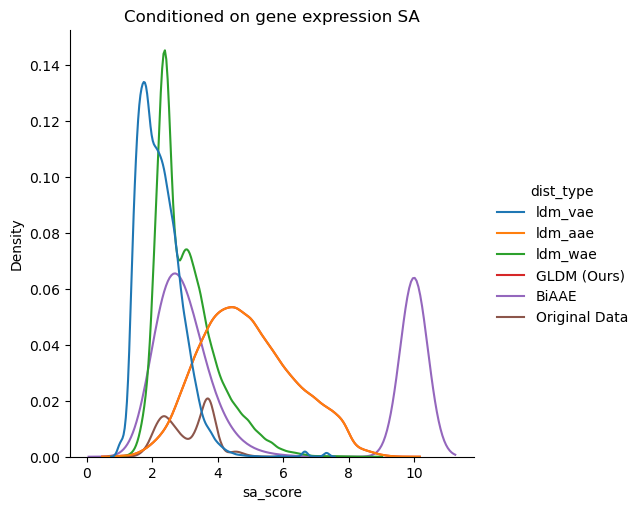

In [15]:
sns.displot(df_l1000_scores ,x = 'sa_score',  hue="dist_type", kind = 'kde')
plt.title('Conditioned on gene expression SA')

Text(0.5, 1.0, 'Conditioned on gene expression QED')

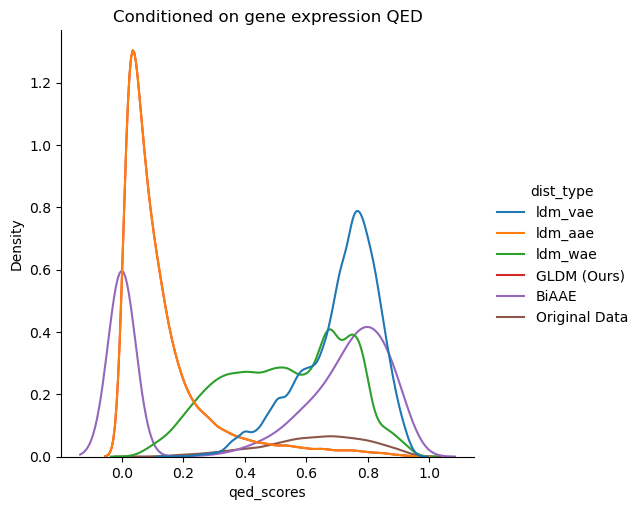

In [16]:
sns.displot(df_l1000_scores ,x = 'qed_scores',  hue="dist_type", kind = 'kde')
plt.title('Conditioned on gene expression QED') 

In [17]:
def map_legend(score_dict):
    new_dict = {}
    for k, v in score_dict.items():
        if 'ldm' in k:
            loss = k.split('_')[1].upper()
            if loss == 'AAE':
                loss = 'GAN'
            new_k = r"GLDM ($L_{{reg}}=L_{{{}}}$)".format(loss)
            new_dict[new_k] = round(v, 2)
        else:
            new_dict[k] = round(v, 2)
    return new_dict

In [18]:
pct_easily_syn = {}
for dist_type in df_l1000_scores['dist_type'].unique():
    sa_scores = df_l1000_scores[df_l1000_scores['dist_type'] == dist_type]['sa_score'].to_list()
    pct_easily_syn[dist_type] = len([score for score in sa_scores if score<=4.5])/len(sa_scores)

In [19]:
pct_easily_syn = map_legend(pct_easily_syn)
pct_easily_syn

{'GLDM ($L_{reg}=L_{VAE}$)': 0.99,
 'GLDM ($L_{reg}=L_{GAN}$)': 0.42,
 'GLDM ($L_{reg}=L_{WAE}$)': 0.92,
 'GLDM (Ours)': 0.42,
 'BiAAE': 0.63,
 'Original Data': 0.97}

In [20]:
# for key in [key for key in list(pct_easily_syn.keys()) if 'original' not in key]:
#     if 'original' not in pct_easily_syn:
#         pct_easily_syn[f'conditional_{key}'] = pct_easily_syn.pop(key)

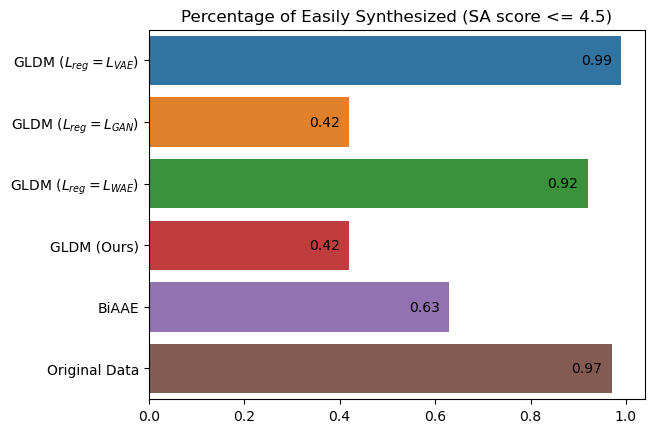

In [21]:
# pct_easily_syn = collections.OrderedDict(sorted(pct_easily_syn.items(), key = lambda x: x[0].split('_')[1]))

ax = sns.barplot(
    y = list(pct_easily_syn.keys()), 
    x = list(pct_easily_syn.values()), 
    orient = 'h'
)
# ax.bar_label(ax.containers[0])

# Iterate over the bars
for p in ax.patches:
    # Get the width of the bar (which is also its value)
    width = p.get_width()
    # Add a text label for the bar's value
    ax.text(width-0.02, p.get_y() + p.get_height() / 2, f'{width}', ha="right", va="center")

plt.title('Percentage of Easily Synthesized (SA score <= 4.5)')

# plt.savefig('../plots/sa/cond_SA.png', bbox_inches='tight')

In [22]:
avg_qed_conditioned = {}
for dist_type in df_l1000_scores['dist_type'].unique():
    qed_score = df_l1000_scores[df_l1000_scores['dist_type'] == dist_type]['qed_scores'].to_list()
#     avg_qed_conditioned[f'conditional_{dist_type}'] = sum(qed_score)/len(qed_score)
    avg_qed_conditioned[dist_type] = sum(qed_score)/len(qed_score)    

In [23]:
avg_qed_conditioned = map_legend(avg_qed_conditioned)
avg_qed_conditioned

{'GLDM ($L_{reg}=L_{VAE}$)': 0.71,
 'GLDM ($L_{reg}=L_{GAN}$)': 0.13,
 'GLDM ($L_{reg}=L_{WAE}$)': 0.54,
 'GLDM (Ours)': 0.13,
 'BiAAE': 0.48,
 'Original Data': 0.63}

Text(0.5, 1.0, 'Average QED')

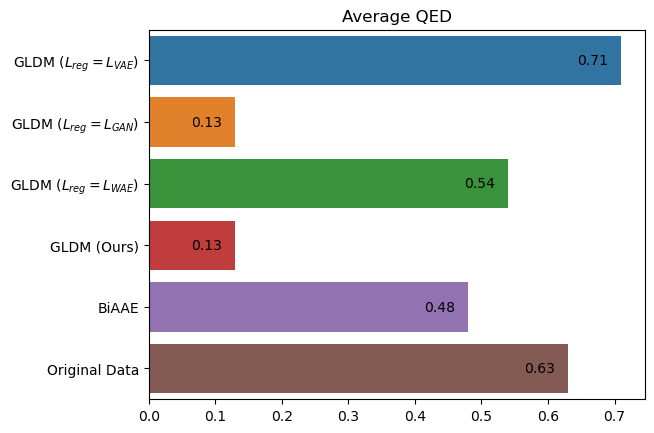

In [24]:
# avg_qed_conditioned = collections.OrderedDict(sorted(avg_qed_conditioned.items()))#, key = lambda x: x[0].split('_')[1]))

ax_qed = sns.barplot(
    y = list(avg_qed_conditioned.keys()), 
    x = list(avg_qed_conditioned.values()), 
    orient = 'h'
)

# Iterate over the bars
for p in ax_qed.patches:
    # Get the width of the bar (which is also its value)
    width = p.get_width()
    # Add a text label for the bar's value
    ax_qed.text(width-0.02, p.get_y() + p.get_height() / 2, f'{width}', ha="right", va="center")
    
plt.title('Average QED')

# plt.savefig('../plots/qed/cond_QED.png', bbox_inches='tight')